In [1]:
import warnings

# Filter out the specific warning
warnings.filterwarnings("ignore", message="Unable to import Axes3D", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv("SeoulBikeData.csv")
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      8760 non-null   object 
 1   Rented Bike Count         8760 non-null   int64  
 2   Hour                      8760 non-null   int64  
 3   Temperature(C)            8760 non-null   float64
 4   Humidity(%)               8760 non-null   int64  
 5   Wind speed (m/s)          8760 non-null   float64
 6   Visibility (10m)          8760 non-null   int64  
 7   Dew point temperature(C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)   8760 non-null   float64
 9   Rainfall(mm)              8760 non-null   float64
 10  Snowfall (cm)             8760 non-null   float64
 11  Seasons                   8760 non-null   object 
 12  Holiday                   8760 non-null   object 
 13  Functioning Day           8760 non-null   object 
dtypes: float

In [5]:
df.duplicated().sum()

0

In [6]:
df.nunique()

Date                         365
Rented Bike Count           2166
Hour                          24
Temperature(C)               546
Humidity(%)                   90
Wind speed (m/s)              65
Visibility (10m)            1789
Dew point temperature(C)     556
Solar Radiation (MJ/m2)      345
Rainfall(mm)                  61
Snowfall (cm)                 51
Seasons                        4
Holiday                        2
Functioning Day                2
dtype: int64

In [7]:
df.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


# Target & Feature Engineering

Check distributions of categorical features

In [8]:
df.groupby('Seasons')['Rented Bike Count'].sum()

Seasons
Autumn    1790002
Spring    1611909
Summer    2283234
Winter     487169
Name: Rented Bike Count, dtype: int64

In [9]:
df.groupby('Holiday')['Rented Bike Count'].sum()

Holiday
Holiday        215895
No Holiday    5956419
Name: Rented Bike Count, dtype: int64

In [10]:
df.groupby('Functioning Day')['Rented Bike Count'].sum()

Functioning Day
No           0
Yes    6172314
Name: Rented Bike Count, dtype: int64

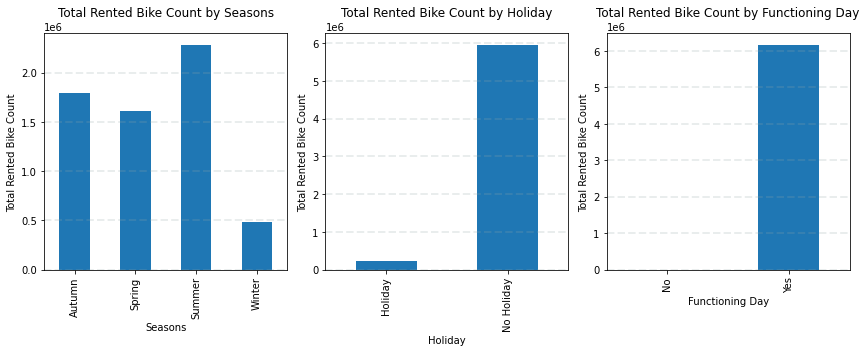

In [11]:
categorical_col = ['Seasons', 'Holiday', 'Functioning Day']

fig = plt.figure(figsize=(12, 5))
for index, column in enumerate(categorical_col):
    plt.subplot(1, 3, index+1)
    dataset = df.copy()
    dataset.groupby(column)['Rented Bike Count'].sum().plot(kind='bar')
    plt.ylabel('Total Rented Bike Count')
    plt.title(f'Total Rented Bike Count by {column}')
    plt.tight_layout()
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)

plt.show()

No bike is rented out on non-functioning days, drop non-functioning records and the columns

In [12]:
# Drop records where 'Functioning Day' is non-functioning
df=df[df['Functioning Day']=='Yes']

# Drop the 'Functioning Day' column
df=df.drop(columns=['Functioning Day']).reset_index().drop(columns=['index'])
df.shape

(8465, 13)

# Check the pairwise correlations between numerical columns

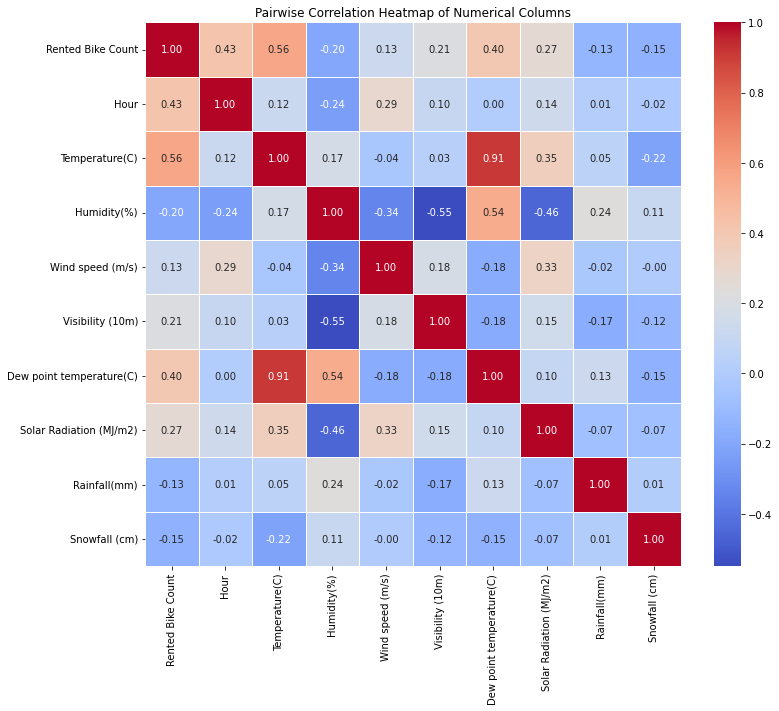

In [13]:
# Select numerical columns
numerical_columns = ['Rented Bike Count', 'Hour', 'Temperature(C)', 'Humidity(%)',
                     'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
                     'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']

# Calculate pairwise correlations
correlation_matrix = df[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Pairwise Correlation Heatmap of Numerical Columns')
plt.show()

Dew point temperature is highly correlated with temperature, drop dew point temperature to avoid multicollinearity

In [14]:
df.drop(columns=['Dew point temperature(C)'],inplace=True)
df.head()

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,1/12/2017,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday
1,1/12/2017,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday
2,1/12/2017,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday
3,1/12/2017,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday
4,1/12/2017,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday


Check distributions of numerical columns

In [15]:
# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

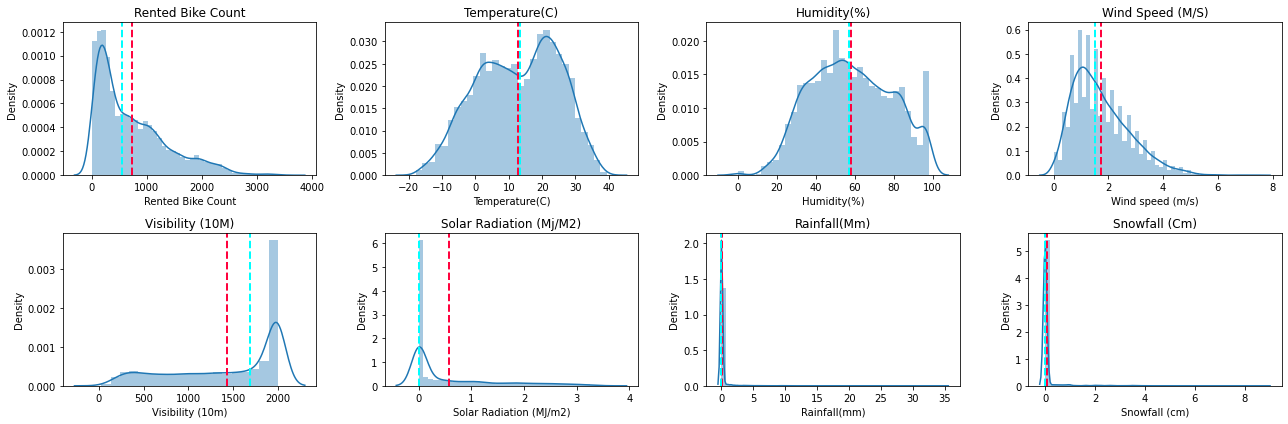

In [16]:
# numerical columns
numerical_col=['Rented Bike Count', 'Temperature(C)', 'Humidity(%)',
                'Wind speed (m/s)', 'Visibility (10m)', 'Solar Radiation (MJ/m2)',
                'Rainfall(mm)', 'Snowfall (cm)']

# Plot histograms for each numerical column
fig = plt.figure(figsize = (18,6))
for index,column in enumerate(numerical_col):
    plt.subplot(2,4,index+1)
    sns.distplot(df[column])
    feature = df[column]
    ax = fig.gca()
    ax.axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
    ax.axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
    plt.title(f'{column.title()}')
    plt.tight_layout()

Right Skewed: Rented Bike Count, Wind Speed, Solar Radiation
No Skew: Temperature, Humidity, Rainfall, Snowfall
Left Skewed: Visibility

# Different transformation techniques for the target

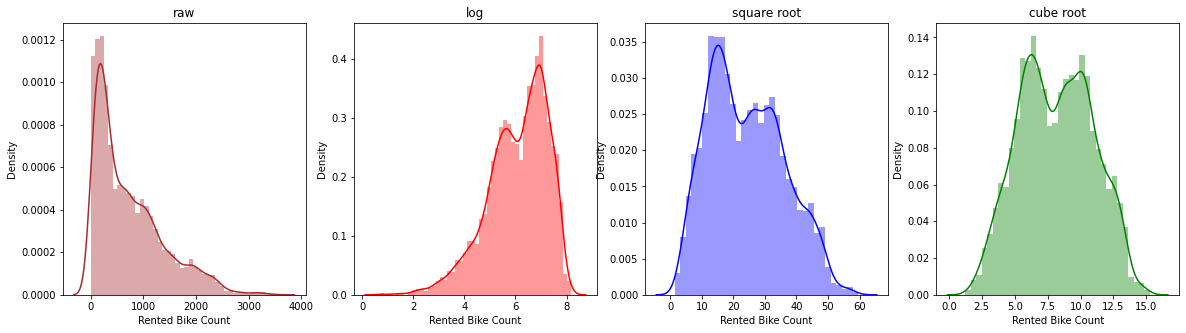

In [17]:
fig,axes = plt.subplots(1,4,figsize=(20,5))
sns.distplot((df['Rented Bike Count']),ax=axes[0],color='brown').set_title("raw")
sns.distplot(np.log(df['Rented Bike Count']),ax=axes[1],color='red').set_title("log")
sns.distplot(np.sqrt(df['Rented Bike Count']),ax=axes[2], color='blue').set_title("square root")
sns.distplot(np.cbrt(df['Rented Bike Count']),ax=axes[3], color='green').set_title("cube root")
plt.show();

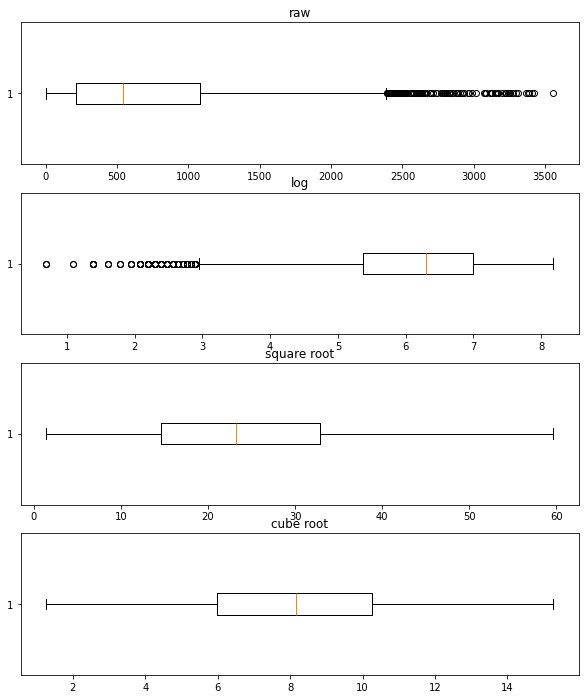

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,12))
ax1.boxplot(df['Rented Bike Count'],vert=False)
ax1.set_title("raw")
ax2.boxplot(np.log(df['Rented Bike Count']),vert=False)
ax2.set_title("log")
ax3.boxplot(np.sqrt(df['Rented Bike Count']),vert=False)
ax3.set_title("square root")
ax4.boxplot(np.cbrt(df['Rented Bike Count']),vert=False)
ax4.set_title("cube root")
plt.show();

Apply cube root transformation to the target

In [19]:
df["Rented Bike Count"]=np.cbrt(df['Rented Bike Count'])
df

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,1/12/2017,6.333026,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday
1,1/12/2017,5.886765,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday
2,1/12/2017,5.572055,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday
3,1/12/2017,4.747459,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday
4,1/12/2017,4.272659,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...
8460,30/11/2018,10.009990,19,4.2,34,2.6,1894,0.0,0.0,0.0,Autumn,No Holiday
8461,30/11/2018,9.141787,20,3.4,37,2.3,2000,0.0,0.0,0.0,Autumn,No Holiday
8462,30/11/2018,8.853599,21,2.6,39,0.3,1968,0.0,0.0,0.0,Autumn,No Holiday
8463,30/11/2018,8.929490,22,2.1,41,1.0,1859,0.0,0.0,0.0,Autumn,No Holiday


Try different transformation techniuqes for other skewed features

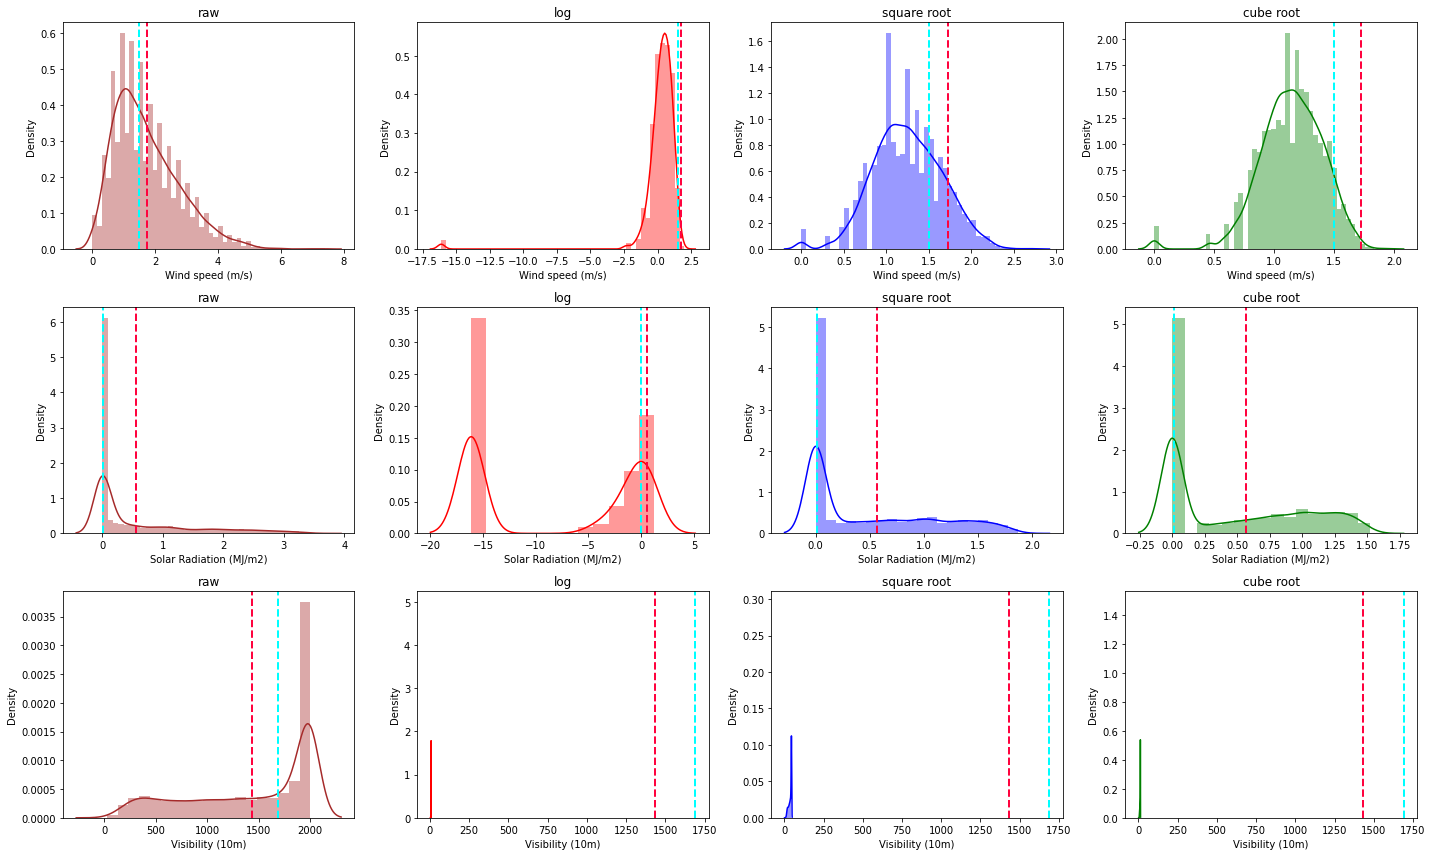

In [20]:
fig,axes = plt.subplots(3,4,figsize=(20,12))
for index, column in enumerate(['Wind speed (m/s)','Solar Radiation (MJ/m2)','Visibility (10m)']):
    feature = df[column]
    sns.distplot((df[column]),ax=axes[index,0],color='brown').set_title("raw")
    axes[index,0].axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
    axes[index,0].axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
    sns.distplot(np.log(df[column]+0.0000001),ax=axes[index,1],color='red').set_title("log")
    axes[index,1].axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
    axes[index,1].axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
    sns.distplot(np.sqrt(df[column]),ax=axes[index,2], color='blue').set_title("square root")
    axes[index,2].axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
    axes[index,2].axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
    sns.distplot(np.cbrt(df[column]),ax=axes[index,3], color='green').set_title("cube root")
    axes[index,3].axvline(feature.mean(), color='#ff033e', linestyle='dashed', linewidth=2)  #Rose-Red Color indicate mean of data
    axes[index,3].axvline(feature.median(), color='#00ffff', linestyle='dashed', linewidth=2) #Cyan indicate median of data
    plt.tight_layout()

Apply square root transformation to the 'Wind speed (m/s)'

In [21]:
df['Wind speed (m/s)']=np.sqrt(df['Wind speed (m/s)'])

# Check time columns

Extract day, month and year from date column and delete date

In [22]:
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

df['Day']=df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year

df.drop(columns=['Date'],inplace=True)

df

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day,Month,Year
0,6.333026,0,-5.2,37,1.483240,2000,0.0,0.0,0.0,Winter,No Holiday,1,12,2017
1,5.886765,1,-5.5,38,0.894427,2000,0.0,0.0,0.0,Winter,No Holiday,1,12,2017
2,5.572055,2,-6.0,39,1.000000,2000,0.0,0.0,0.0,Winter,No Holiday,1,12,2017
3,4.747459,3,-6.2,40,0.948683,2000,0.0,0.0,0.0,Winter,No Holiday,1,12,2017
4,4.272659,4,-6.0,36,1.516575,2000,0.0,0.0,0.0,Winter,No Holiday,1,12,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,10.009990,19,4.2,34,1.612452,1894,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8461,9.141787,20,3.4,37,1.516575,2000,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8462,8.853599,21,2.6,39,0.547723,1968,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018
8463,8.929490,22,2.1,41,1.000000,1859,0.0,0.0,0.0,Autumn,No Holiday,30,11,2018


Check distributions of time columns

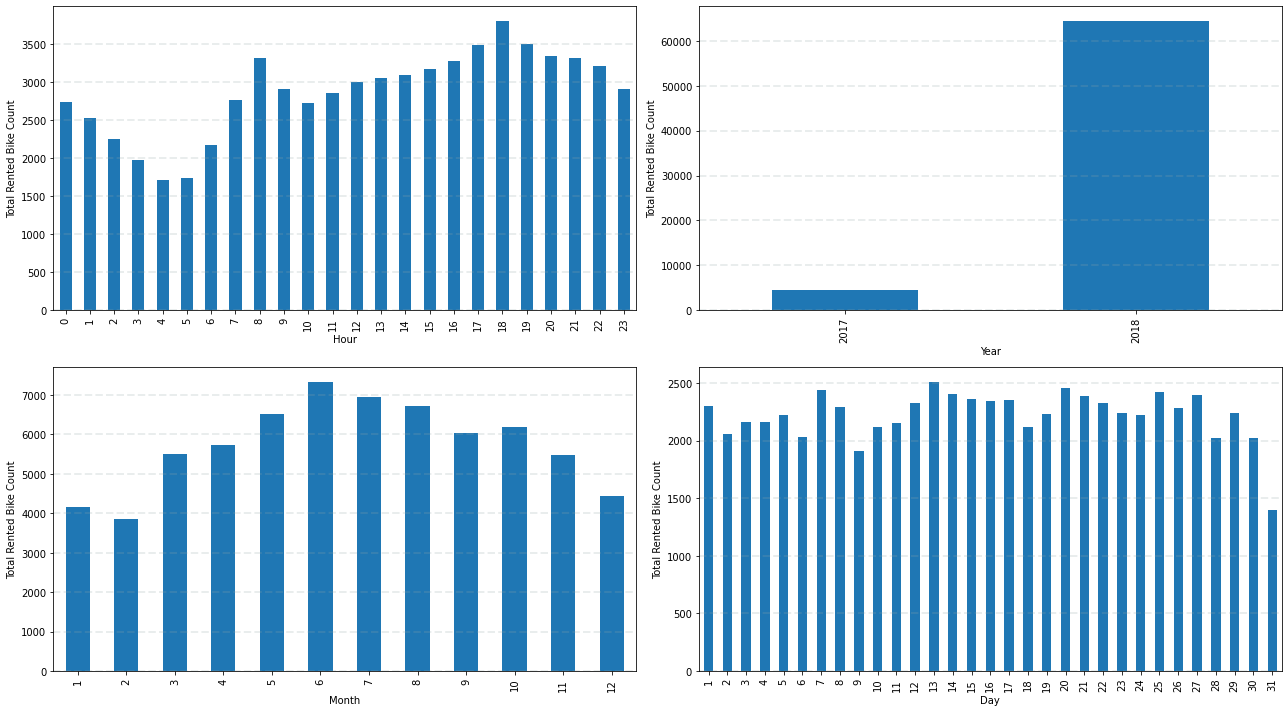

In [23]:
time_col=['Hour','Year','Month','Day']

fig = plt.figure(figsize = (18,10))
for index,column in enumerate(time_col) :
    plt.subplot(2,2,index+1)
    dataset=df.copy()
    dataset.groupby(column)['Rented Bike Count'].sum().plot(kind='bar')
    ax = fig.gca()
    plt.ylabel('Total Rented Bike Count')
    plt.tight_layout()
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)

# Encode Cyclical Features

In [24]:
df['Hour_sin'] = np.sin(df.Hour*(2.*np.pi/24))
df['Hour_cos'] = np.cos(df.Hour*(2.*np.pi/24))
df['Month_sin'] = np.sin((df.Month-1)*(2.*np.pi/12))
df['Month_cos'] = np.cos((df.Month-1)*(2.*np.pi/12))
df['Day_sin'] = np.sin((df.Day-1)*(2.*np.pi/31))
df['Day_cos'] = np.cos((df.Day-1)*(2.*np.pi/31))
df=df.drop(columns=['Day','Month','Hour'])
df

,Rented Bike Count,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Year,Hour_sin,Hour_cos,Month_sin,Month_cos,Day_sin,Day_cos
0,6.333026,-5.2,37,1.483240,2000,0.0,0.0,0.0,Winter,No Holiday,2017,0.000000,1.000000,-0.500000,0.866025,0.000000,1.000000
1,5.886765,-5.5,38,0.894427,2000,0.0,0.0,0.0,Winter,No Holiday,2017,0.258819,0.965926,-0.500000,0.866025,0.000000,1.000000
2,5.572055,-6.0,39,1.000000,2000,0.0,0.0,0.0,Winter,No Holiday,2017,0.500000,0.866025,-0.500000,0.866025,0.000000,1.000000
3,4.747459,-6.2,40,0.948683,2000,0.0,0.0,0.0,Winter,No Holiday,2017,0.707107,0.707107,-0.500000,0.866025,0.000000,1.000000
4,4.272659,-6.0,36,1.516575,2000,0.0,0.0,0.0,Winter,No Holiday,2017,0.866025,0.500000,-0.500000,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,10.009990,4.2,34,1.612452,1894,0.0,0.0,0.0,Autumn,No Holiday,2018,-0.965926,0.258819,-0.866025,0.500000,-0.394356,0.918958
8461,9.141787,3.4,37,1.516575,2000,0.0,0.0,0.0,Autumn,No Holiday,2018,-0.866025,0.500000,-0.866025,0.500000,-0.394356,0.918958
8462,8.853599,2.6,39,0.547723,1968,0.0,0.0,0.0,Autumn,No Holiday,2018,-0.707107,0.707107,-0.866025,0.500000,-0.394356,0.918958
8463,8.929490,2.1,41,1.000000,1859,0.0,0.0,0.0,Autumn,No Holiday,2018,-0.500000,0.866025,-0.866025,0.500000,-0.394356,0.918958


# Train test split

In [25]:
X = df.drop(columns=['Rented Bike Count'])
y = df['Rented Bike Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((6772, 16), (1693, 16))

# Build the preprocessing column transformer

In [26]:
numerical_feat=['Temperature(C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)',
                'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
                'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']
categorical_feat=['Holiday','Seasons','Year']

preproc = make_column_transformer(
    (MinMaxScaler(), numerical_feat),
    (OneHotEncoder(handle_unknown="ignore"), categorical_feat),
)
X_train_preproc=preproc.fit_transform(X_train)

pd.DataFrame(X_train_preproc, columns=preproc.get_feature_names_out())

,minmaxscaler__Temperature(C),minmaxscaler__Humidity(%),minmaxscaler__Wind speed (m/s),minmaxscaler__Visibility (10m),minmaxscaler__Solar Radiation (MJ/m2),minmaxscaler__Rainfall(mm),minmaxscaler__Snowfall (cm),minmaxscaler__Hour_sin,minmaxscaler__Hour_cos,minmaxscaler__Month_sin,...,minmaxscaler__Day_sin,minmaxscaler__Day_cos,onehotencoder__Holiday_Holiday,onehotencoder__Holiday_No Holiday,onehotencoder__Seasons_Autumn,onehotencoder__Seasons_Spring,onehotencoder__Seasons_Summer,onehotencoder__Seasons_Winter,onehotencoder__Year_2017,onehotencoder__Year_2018
0,0.373030,0.387755,0.464991,0.446021,0.000000,0.000000,0.0,0.853553,0.853553,0.066987,...,0.137138,0.844083,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.803853,0.877551,0.557504,0.616827,0.079545,0.014286,0.0,0.000000,0.500000,0.250000,...,1.000000,0.473324,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.809107,0.459184,0.545250,0.315256,0.829545,0.000000,0.0,0.500000,0.000000,0.750000,...,0.350126,0.020417,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.733800,0.816327,0.348743,0.924987,0.000000,0.000000,0.0,0.250000,0.933013,0.250000,...,0.399221,0.989739,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.558669,0.469388,0.677834,0.969589,0.002841,0.000000,0.0,0.066987,0.750000,0.933013,...,0.786001,0.910151,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6767,0.844133,0.459184,0.464991,1.000000,0.000000,0.000000,0.0,0.250000,0.933013,0.500000,...,0.213999,0.910151,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6768,0.654991,0.581633,0.464991,1.000000,0.119318,0.000000,0.0,0.982963,0.370590,0.500000,...,0.969479,0.672813,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6769,0.879159,0.510204,0.519875,0.865687,0.889205,0.000000,0.0,0.250000,0.066987,0.500000,...,0.649874,0.020417,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
6770,0.252189,0.520408,0.385550,0.691333,0.000000,0.000000,0.0,0.066987,0.750000,0.500000,...,0.862862,0.844083,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


# Baseline model: Linear Regression

Build the pipeline

In [27]:
model=LinearRegression()
pipe_baseline = make_pipeline(preproc, model)
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['Temperature(C)',
                                                   'Humidity(%)',
                                                   'Wind speed (m/s)',
                                                   'Visibility (10m)',
                                                   'Solar Radiation (MJ/m2)',
                                                   'Rainfall(mm)',
                                                   'Snowfall (cm)', 'Hour_sin',
                                                   'Hour_cos', 'Month_sin',
                                                   'Month_cos', 'Day_sin',
                                                   'Day_cos']),
                                                 ('onehotencoder',
                                              

5-folder cross validation

In [28]:
cross_val_result_baseline=cross_validate(pipe_baseline, X_train, y_train, cv=5,
                                         scoring=('r2', 'neg_root_mean_squared_error'),
                                         return_train_score=True)

print(f"Mean validation r2: {cross_val_result_baseline['test_r2'].mean()}")
print(f"Mean validation rmse: {abs(cross_val_result_baseline['test_neg_root_mean_squared_error'].mean())}")

Mean validation r2: 0.6351267649899637
Mean validation rmse: 1.6880980822581495


# Decision Tree Regression

In [29]:
model=DecisionTreeRegressor()
pipe_DTR = make_pipeline(preproc, model)

cross_val_result_DTR=cross_validate(pipe_DTR, X_train, y_train, cv=5,
                                    scoring=('r2', 'neg_root_mean_squared_error'),
                                    return_train_score=True)

print(f"Mean validation r2: {cross_val_result_DTR['test_r2'].mean()}")
print(f"Mean validation rmse: {abs(cross_val_result_DTR['test_neg_root_mean_squared_error'].mean())}")

Mean validation r2: 0.7882329807368917
Mean validation rmse: 1.2849147749137517


# Support Vector Regressor (SVM)

In [30]:
model = SVR(kernel='poly')
pipe_SVM = make_pipeline(preproc, model)

cross_val_result_SVM=cross_validate(pipe_SVM, X_train, y_train, cv=5,
                                   scoring=('r2', 'neg_root_mean_squared_error'),
                                   return_train_score=True)

print(f"Mean validation r2: {cross_val_result_SVM['test_r2'].mean()}")
print(f"Mean validation rmse: {abs(cross_val_result_SVM['test_neg_root_mean_squared_error'].mean())}")

Mean validation r2: 0.7925280092306387
Mean validation rmse: 1.2732469335397154


# K-Nearest Neighbors Regressor (KNN)

In [31]:
model=KNeighborsRegressor()
pipe_KNN = make_pipeline(preproc, model)

cross_val_result_KNN=cross_validate(pipe_KNN, X_train, y_train, cv=5,
                                    scoring=('r2', 'neg_root_mean_squared_error'),
                                    return_train_score=True)

print(f"Mean validation r2: {cross_val_result_KNN['test_r2'].mean()}")
print(f"Mean validation rmse: {abs(cross_val_result_KNN['test_neg_root_mean_squared_error'].mean())}")

Mean validation r2: 0.8460089575102095
Mean validation rmse: 1.0970746198044765


Fine tuning with grid search

In [32]:
param_grid =  {'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30]}
search_KNN = GridSearchCV(
        pipe_KNN,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=2,
        scoring="neg_root_mean_squared_error"
    )

search_KNN.fit(X_train, y_train);

print('\n----------------------------------------\n')
print(f'Best params: {search_KNN.best_params_}')
print(f'Best rmse: {abs(search_KNN.best_score_)}')

Fitting 5 folds for each of 11 candidates, totalling 55 fits

----------------------------------------

Best params: {'kneighborsregressor__n_neighbors': 3}
Best rmse: 1.037385417119116


5-folder cross validation using the best model

In [33]:
best_KNN=KNeighborsRegressor(n_neighbors=3)
pipe_best_KNN = make_pipeline(preproc, best_KNN)

cross_val_result_best_KNN=cross_validate(pipe_best_KNN, X_train, y_train, cv=5,
                                    scoring=('r2', 'neg_root_mean_squared_error'),
                                    return_train_score=True)

print(f"Mean validation r2: {cross_val_result_best_KNN['test_r2'].mean()}")
print(f"Mean validation rmse: {abs(cross_val_result_best_KNN['test_neg_root_mean_squared_error'].mean())}")

Mean validation r2: 0.8623720075181636
Mean validation rmse: 1.037385417119116


# XGBoost Regressor

In [34]:
model_XGB = XGBRegressor()
pipe_XGB= make_pipeline(preproc, model_XGB)
cross_val_result_XGB=cross_validate(pipe_XGB, X_train, y_train, cv=5,
                                    scoring=('r2', 'neg_root_mean_squared_error'),
                                    return_train_score=True)

print(f"Mean validation r2: {cross_val_result_XGB['test_r2'].mean()}")
print(f"Mean validation rmse: {abs(cross_val_result_XGB['test_neg_root_mean_squared_error'].mean())}")

Mean validation r2: 0.9054155847248708
Mean validation rmse: 0.8595249529972915


In [35]:
X_train_train, X_train_eval, y_train_train, y_train_eval = train_test_split(X_train, y_train, test_size=0.2,
                                                                            random_state=42)
X_train_train_preproc = preproc.fit_transform(X_train_train)
X_train_eval_preproc = preproc.transform(X_train_eval)

model_XGB = XGBRegressor(eval_metric="rmse")

param_grid = {'max_depth': [6,10],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [100, 500, 1000]}

fit_params = {"early_stopping_rounds": 5,
              "eval_set": [(X_train_eval_preproc, y_train_eval)]}

search_XGB = GridSearchCV(
        model_XGB,
        param_grid=param_grid,
        cv=3,
        n_jobs=-1,
        verbose=0,
        scoring='neg_root_mean_squared_error'
    )

search_XGB.fit(X_train_train_preproc, y_train_train, **fit_params)
print('\n----------------------------------------\n')
print(f'Best params: {search_XGB.best_params_}')
print(f'Best rmse: {abs(search_XGB.best_score_)}')

[0]	validation_0-rmse:2.66507
[1]	validation_0-rmse:2.56157
[2]	validation_0-rmse:2.46487
[3]	validation_0-rmse:2.37417
[4]	validation_0-rmse:2.28799
[5]	validation_0-rmse:2.20649
[6]	validation_0-rmse:2.13052
[7]	validation_0-rmse:2.06088
[8]	validation_0-rmse:1.99297
[9]	validation_0-rmse:1.93057
[10]	validation_0-rmse:1.87237
[11]	validation_0-rmse:1.81875
[12]	validation_0-rmse:1.76674
[13]	validation_0-rmse:1.71594
[14]	validation_0-rmse:1.66824
[15]	validation_0-rmse:1.62222
[16]	validation_0-rmse:1.58165
[17]	validation_0-rmse:1.54257
[18]	validation_0-rmse:1.50501
[19]	validation_0-rmse:1.47120
[20]	validation_0-rmse:1.43936
[21]	validation_0-rmse:1.40970
[22]	validation_0-rmse:1.38068
[23]	validation_0-rmse:1.35523
[24]	validation_0-rmse:1.32994
[25]	validation_0-rmse:1.30793
[26]	validation_0-rmse:1.28756
[27]	validation_0-rmse:1.26725
[28]	validation_0-rmse:1.24807
[29]	validation_0-rmse:1.23190
[30]	validation_0-rmse:1.21554
[31]	validation_0-rmse:1.19972
[32]	validation_0-

Fit the model with the best hyperparameters

In [36]:
model_xgb_early_stopping = XGBRegressor(max_depth=6,
                           n_estimators=500,
                           eval_metric="rmse",
                           learning_rate=0.05,
                           early_stopping_rounds=5)

model_xgb_early_stopping.fit(
    X_train_train_preproc,
    y_train_train,
    verbose=False,
    eval_set=[(X_train_train_preproc, y_train_train), (X_train_eval_preproc, y_train_eval)],
)

results = model_xgb_early_stopping.evals_result()

Plot the train and validation loss

Best Train rmse 0.5882614109158141
Best Validation rmse 0.9006300382955853


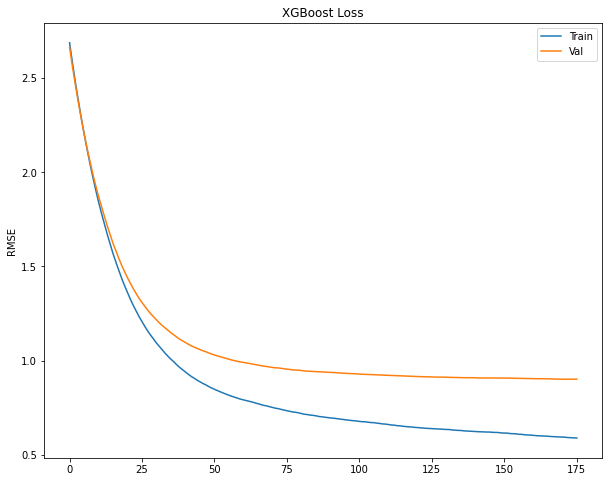

In [37]:
epochs = len(results['validation_0']["rmse"])
x_axis = range(0, epochs)

# Plot RMSLE loss
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend(); plt.ylabel('RMSE'); plt.title('XGBoost Loss')

print("Best Train rmse", min(results['validation_0']['rmse']))
print("Best Validation rmse", min(results['validation_1']['rmse']))

Predit with the model and compute the test score

In [38]:
X_test_preproc = preproc.transform(X_test)
y_pred=model_xgb_early_stopping.predict(X_test_preproc)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2, rmse

(0.8978955149651827, 0.8674814746606966)

Plot the actual bike count vs. predicted bike count for chosen indices

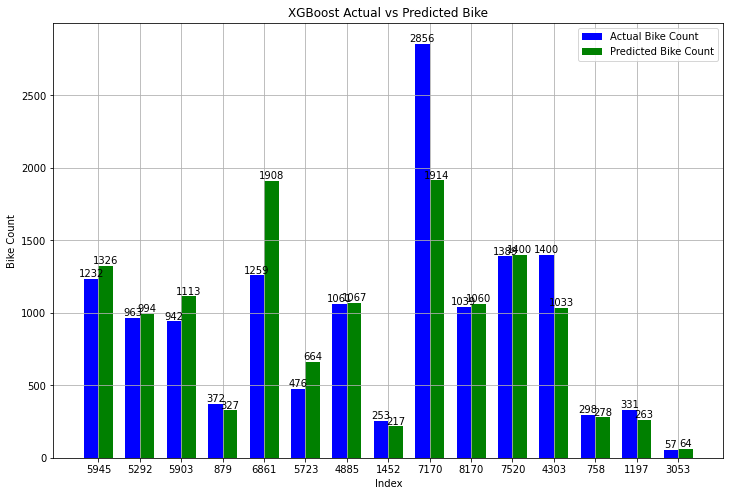

In [39]:
# Create a DataFrame for actual and rounded predicted bike counts
df_predictions = pd.DataFrame({'Actual Bike Count': np.power(y_test, 3),
                               'Predicted Bike Count': np.round(np.power(y_pred, 3))})

# Select a subset of data for plotting (e.g., first 15 rows)
subset_df = df_predictions.iloc[:15]

# Create a bar graph to compare actual and predicted bike counts
plt.figure(figsize=(12, 8))
width = 0.35
index = np.arange(len(subset_df))

plt.bar(index, subset_df['Actual Bike Count'], width, label='Actual Bike Count', color='blue')
plt.bar(index + width, subset_df['Predicted Bike Count'], width, label='Predicted Bike Count', color='green')

# Add labels to the bars
for i, actual_count, predicted_count in zip(index, subset_df['Actual Bike Count'], subset_df['Predicted Bike Count']):
    plt.text(i, actual_count, str(int(actual_count)), ha='center', va='bottom', fontsize=10)
    plt.text(i + width, predicted_count, str(int(predicted_count)), ha='center', va='bottom', fontsize=10)

plt.xlabel('Index')
plt.ylabel('Bike Count')
plt.title('XGBoost Actual vs Predicted Bike')
plt.xticks(index + width/2, subset_df.index)
plt.legend()
plt.grid(True)
plt.show()

# Results/Summary

The XGBoost model provide the performance, with the highest R-squared value and the lowest RMSE, indicating its effectiveness in predicting bike rental demand in Seoul.

This model, optimized with the best hyperparameters using grid search, offers actionable insights for strategic decision-making in bike rental services.
